In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from fgclassifier.baseline import MultiOutputClassifier,Baseline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

In [123]:
import config
from collections import defaultdict
from sklearn.model_selection import train_test_split
from fgclassifier.features import SparseToDense
from fgclassifier.baseline import MultiOutputClassifier,Baseline
from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'), flavor=None, sample_n=1000)

2018-12-04 00:01:38,240 [INFO] Take 1000 samples with random state 1


In [7]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=200)),
    ('model', MultiOutputClassifier(LDA()))
])

parameters = {
    'vect__min_df': np.linspace(0.01,0.1,10),
    'vect__ngram_range': ((1, 1),(1, 2),(1, 3),(1, 4),(1, 5),(1, 6))
}

grid_search = GridSearchCV(pipeline, parameters, cv=3,
                               n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...age=None,
              solver='svd', store_covariance=False, tol=0.0001),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__min_df': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6))},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [56]:
results = pd.melt(
pd.DataFrame(grid_search.cv_results_),
id_vars=['param_vect__min_df', 'param_vect__ngram_range'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/si

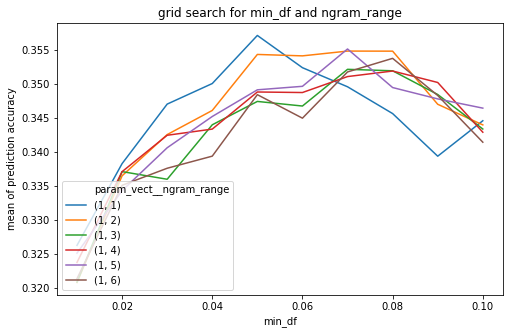

In [12]:
def plot_results(results, title=r'grid search for min_df and ngram_range'):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x='param_vect__min_df',
    y='f1_scores',
    hue = 'param_vect__ngram_range',
    data=results)
    ax.set_xlabel(r'min_df')
    ax.set_ylabel('mean of prediction accuracy')
    ax.set_title(title)
    ax.legend(loc='lower left')
plot_results(results)

In [28]:
grid_search.best_params_

NameError: name 'grid_search' is not defined

According to the grid search, 0.5-0.8 could be the possible range for min_df when the number of observation is 1000.
There is little difference between different value of ngram_range.

## Tune the parameters of SVD

In [166]:
pipeline_svd = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,2))),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD()),
    ('model', MultiOutputClassifier(LDA()))
])

parameters_svd = {
    'svd__n_components': (100,200,250,280,300),
    'vect__min_df': np.linspace(0.01,0.1,10)
}

grid_search_svd = GridSearchCV(pipeline_svd, parameters_svd, cv=3,
                               n_jobs=-1, verbose=True)
grid_search_svd.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...age=None,
              solver='svd', store_covariance=False, tol=0.0001),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'svd__n_components': (100, 200, 250, 280, 300), 'vect__min_df': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [181]:
results_svd = pd.melt(
pd.DataFrame(grid_search_svd.cv_results_),
id_vars=['param_svd__n_components', 'param_vect__min_df'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)
results_svd = results_svd.drop(['variable'], axis=1)
results_svd.param_svd__n_components = pd.to_numeric(results_svd.param_svd__n_components)

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/si

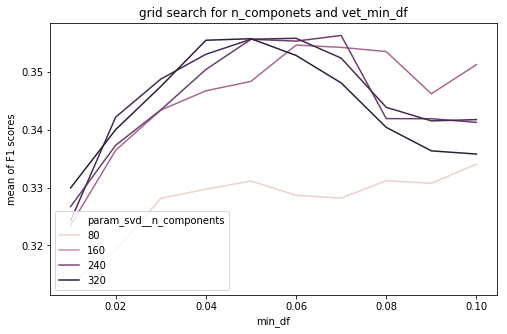

In [182]:
def plot_results_svd(results, title=r'grid search for n_componets and vet_min_df'):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x='param_vect__min_df',
    y='f1_scores',
    hue = 'param_svd__n_components',
    data=results)
    ax.set_xlabel(r'min_df')
    ax.set_ylabel('mean of F1 scores')
    ax.set_title(title)
    ax.legend(loc='lower left')
plot_results_svd(results_svd)

In [183]:
grid_search_svd.best_params_

{'svd__n_components': 250, 'vect__min_df': 0.07}

We get about 400-500 features from 1000 sample comments. According to the grid search, 250-300 componets with min_df 0.07 produce the best result. The componets might be around 50%-60% of the total features. The value of min_df choosed by the grid search is close that of last grid search.

## Tune the parameters of SVM

In [153]:
MaxAbsScaler_scaler = preprocessing.MaxAbsScaler()
pipeline_svm = Pipeline([
    ('vect', CountVectorizer(min_df = 0.06,ngram_range = (1,1))),
    ('tfidf', TfidfTransformer())
], memory='data/pipeline_cache')

Xt = pipeline_svm.fit_transform(X_train)
Xt = MaxAbsScaler_scaler.fit_transform(Xt)


clf = MultiOutputClassifier(SVC())
parameters = {
    'estimator': [
        SVC(C=n,kernel = m)
        for n in np.linspace(0.1,100,5)
        for m in ('linear', 'poly', 'rbf', 'sigmoid')
    ]
}


grid_search_svm = GridSearchCV(clf, parameters, cv=4, verbose=True)
grid_search_svm.fit(Xt, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
2018-12-04 10:59:36,850 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:36,853 [INFO]   location_traffic_convenience            	0.3849
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:36,855 [INFO]   location_distance_from_business_district	0.2271
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', 

2018-12-04 10:59:42,870 [INFO]   price_level                             	0.5427
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:42,874 [INFO]   price_cost_effective                    	0.3330
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:42,877 [INFO]   price_discount                          	0.4560
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:42,880 [INFO]   e

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:52,278 [INFO]   dish_taste                              	0.3332
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:52,282 [INFO]   dish_look                               	0.2194
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 10:59:52,284 [INFO]   dish_recommendation                     	0.2233
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:06,254 [INFO]   service_waiters_attitude                	0.4547
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:06,257 [INFO]   service_parking_convenience             	0.2407
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:06,260 [INFO]   service_serving_speed                   	0.2587
2018-12-04 11:00:06,262 [INFO]   p

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:11,638 [INFO]   environment_space                       	0.3838
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:11,641 [INFO]   environment_cleaness                    	0.4051
2018-12-04 11:00:11,648 [INFO]   dish_portion                            	0.3748
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:11,652 [INFO]   d

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:20,410 [INFO]   others_willing_to_consume_again         	0.2663
2018-12-04 11:00:25,738 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:25,741 [INFO]   location_traffic_convenience            	0.3993
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:25,744 [INFO]   location_distance_from_busine

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:31,615 [INFO]   price_level                             	0.1711
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:31,618 [INFO]   price_cost_effective                    	0.2271
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:31,622 [INFO]   price_discount                          	0.2010
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:35,929 [INFO]   environment_cleaness                    	0.1954
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:35,933 [INFO]   dish_portion                            	0.1762
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:35,937 [INFO]   dish_taste                              	0.1748
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:41,653 [INFO]   others_overall_experience               	0.2024
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:41,656 [INFO]   others_willing_to_consume_again         	0.2024
2018-12-04 11:00:45,754 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:45,755 [INFO]   location_traffic_convenience 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:51,538 [INFO]   service_wait_time                       	0.2306
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:51,541 [INFO]   service_waiters_attitude                	0.1469
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:51,543 [INFO]   service_parking_convenience             	0.2407
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:55,786 [INFO]   price_discount                          	0.1921
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:55,789 [INFO]   environment_decoration                  	0.1684
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:00:55,792 [INFO]   environment_noise                       	0.2098
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:01,590 [INFO]   dish_portion                            	0.1778
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:01,592 [INFO]   dish_taste                              	0.1898
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:01,595 [INFO]   dish_look                               	0.2073
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:01:13,663 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:13,666 [INFO]   location_traffic_convenience            	0.2204
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:13,668 [INFO]   location_distance_from_business_distri

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:19,143 [INFO]   service_parking_convenience             	0.2423
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:19,145 [INFO]   service_serving_speed                   	0.2287
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:19,151 [INFO]   price_level                             	0.1708
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:27,042 [INFO]   environment_decoration                  	0.2138
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:27,047 [INFO]   environment_noise                       	0.2038
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:27,055 [INFO]   environment_space                       	0.1851
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:32,576 [INFO]   dish_look                               	0.2086
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:32,579 [INFO]   dish_recommendation                     	0.2245
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:32,582 [INFO]   others_overall_experience               	0.2021
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:45,604 [INFO]   location_distance_from_business_district	0.2199
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:45,606 [INFO]   location_easy_to_find                   	0.2118
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:45,609 [INFO]   service_wait_time                       	0.2325
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:53,263 [INFO]   service_serving_speed                   	0.2271
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:53,266 [INFO]   price_level                             	0.1667
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:53,268 [INFO]   price_cost_effective                    	0.2066
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:58,551 [INFO]   environment_space                       	0.1898
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:58,554 [INFO]   environment_cleaness                    	0.1891
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:01:58,561 [INFO]   dish_portion                            	0.1787
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:05,451 [INFO]   dish_recommendation                     	0.2265
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:05,453 [INFO]   others_overall_experience               	0.1988
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:05,456 [INFO]   others_willing_to_consume_again         	0.1921
2018-12-04 11:02:10,159 [INFO] [Va

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:16,932 [INFO]   location_easy_to_find                   	0.2086
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:16,934 [INFO]   service_wait_time                       	0.2289
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:16,937 [INFO]   service_waiters_attitude                	0.1459
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:21,560 [INFO]   price_cost_effective                    	0.2178
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:21,566 [INFO]   price_discount                          	0.1931
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:21,572 [INFO]   environment_decoration                  	0.1739
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:28,361 [INFO]   environment_cleaness                    	0.1936
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:28,363 [INFO]   dish_portion                            	0.1753
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:28,367 [INFO]   dish_taste                              	0.1667
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:33,073 [INFO]   others_willing_to_consume_again         	0.1951
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:02:39,857 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:39,859 [INFO]   location_traffic_convenience          

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:44,589 [INFO]   service_waiters_attitude                	0.1479
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:44,592 [INFO]   service_parking_convenience             	0.2414
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:02:44,595 [INFO]   service_serving_speed                   	0.2296
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:02:58,146 [INFO]   service_parking_convenience             	1.0000
2018-12-04 11:02:58,149 [INFO]   service_serving_speed                   	1.0000
2018-12-04 11:02:58,152 [INFO]   price_level                             	1.0000
2018-12-04 11:02:58,155 [INFO]   price_cost_effective                    	1.0000
2018-12-04 11:02:58,159 [INFO]   price_discount                          	1.0000
2018-12-04 11:02:58,163 [INFO]   environment_decoration                  	1.0000
2018-12-04 11:02:58,167 [INFO]   environment_noise                       	1.0000
2018-12-04 11:02:58,174 [INFO]   environment_space                       	1.0000
2018-12-04 11:02:58,177 [INFO]   environment_cleaness                    	1.0000
2018-12-04 11:02:58,180 [INFO]   dish_portion                            	1.0000
2018-12-04 11:02:58,183 [INFO]   dish_taste                              	1.0000
2018-12-04 11:02:58,186 [INFO]   dish_look                               	1.0000
2018-12-04 11:02:58,191 [INF

2018-12-04 11:03:20,167 [INFO]   environment_space                       	0.3717
2018-12-04 11:03:20,170 [INFO]   environment_cleaness                    	0.3298
2018-12-04 11:03:20,173 [INFO]   dish_portion                            	0.3155
2018-12-04 11:03:20,178 [INFO]   dish_taste                              	0.3929
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:20,182 [INFO]   dish_look                               	0.2728
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:20,185 [INFO]   dish_recommendation                     	0.3028
2018-12-04 11:03:20,187 [INFO]  

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:44,295 [INFO]   location_traffic_convenience            	0.2204
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:44,298 [INFO]   location_distance_from_business_district	0.2271
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:44,300 [INFO]   location_easy_to_find                   	0.2126
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:48,594 [INFO]   service_serving_speed                   	0.2287
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:48,597 [INFO]   price_level                             	0.1708
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:48,602 [INFO]   price_cost_effective                    	0.2148
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:54,337 [INFO]   environment_noise                       	0.2038
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:54,340 [INFO]   environment_space                       	0.1851
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:54,346 [INFO]   environment_cleaness                    	0.1851
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:58,527 [INFO]   dish_recommendation                     	0.2245
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:58,530 [INFO]   others_overall_experience               	0.2021
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:03:58,533 [INFO]   others_willing_to_consume_again         	0.1929
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:08,438 [INFO]   location_easy_to_find                   	0.2118
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:08,440 [INFO]   service_wait_time                       	0.2325
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:08,443 [INFO]   service_waiters_attitude                	0.1482
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:14,233 [INFO]   price_level                             	0.1667
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:14,237 [INFO]   price_cost_effective                    	0.2066
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:14,240 [INFO]   price_discount                          	0.1898
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:18,481 [INFO]   environment_cleaness                    	0.1891
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:18,484 [INFO]   dish_portion                            	0.1787
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:18,487 [INFO]   dish_taste                              	0.1708
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:27,293 [INFO]   others_willing_to_consume_again         	0.3035
2018-12-04 11:04:32,949 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:32,952 [INFO]   location_traffic_convenience            	0.4171
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:32,955 [INFO]   location_distance_from_busine

2018-12-04 11:04:41,656 [INFO]   price_level                             	0.3361
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:41,659 [INFO]   price_cost_effective                    	0.2957
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:41,661 [INFO]   price_discount                          	0.3216
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:41,666 [INFO]   e

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:47,325 [INFO]   dish_recommendation                     	0.3069
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:47,328 [INFO]   others_overall_experience               	0.5115
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:04:47,331 [INFO]   others_willing_to_consume_again         	0.4245
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:02,484 [INFO]   service_wait_time                       	0.3022
2018-12-04 11:05:02,487 [INFO]   service_waiters_attitude                	0.6632
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:02,490 [INFO]   service_parking_convenience             	0.2421
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:02,493 [INFO]   s

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:11,311 [INFO]   environment_noise                       	0.2897
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:11,314 [INFO]   environment_space                       	0.2835
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:11,319 [INFO]   environment_cleaness                    	0.3474
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:05:25,948 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:25,950 [INFO]   location_traffic_convenience            	0.3166
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:25,953 [INFO]   location_distance_from_business_district	0.2271
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:25,956 [INFO]   location_easy_to_find        

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:31,542 [INFO]   service_serving_speed                   	0.2771
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:31,546 [INFO]   price_level                             	0.2518
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:31,550 [INFO]   price_cost_effective                    	0.2903
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:40,287 [INFO]   environment_noise                       	0.2122
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:40,293 [INFO]   environment_space                       	0.2015
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:40,295 [INFO]   environment_cleaness                    	0.2684
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:45,802 [INFO]   others_overall_experience               	0.2420
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:05:45,805 [INFO]   others_willing_to_consume_again         	0.3071
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:05:54,472 [INFO] [Validate]: 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:00,060 [INFO]   service_wait_time                       	0.2325
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:00,063 [INFO]   service_waiters_attitude                	0.4355
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:00,065 [INFO]   service_parking_convenience             	0.2421
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:08,828 [INFO]   price_discount                          	0.2306
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:08,836 [INFO]   environment_decoration                  	0.3636
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:08,841 [INFO]   environment_noise                       	0.2439
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:14,438 [INFO]   dish_look                               	0.2095
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:14,441 [INFO]   dish_recommendation                     	0.2251
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:14,444 [INFO]   others_overall_experience               	0.2514
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:06:36,591 [INFO]   dish_portion                            	0.2943
2018-12-04 11:06:36,594 [INFO]   dish_taste                              	0.3476
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:06:36,596 [INFO]   dish_look                               	0.2758
2018-12-04 11:06:36,599 [INFO]   dish_recommendation                     	0.3692
2018-12-04 11:06:36,602 [INFO]   others_overall_experience               	0.3864
2018-12-04 11:06:36,605 [INFO]   others_willing_to_consume_again         	0.2693
2018-12-04 11:06:41,381 [INFO] [Validate]: F1 Scores
2018-12-04 11:06:41,383 [INFO]   location_traffic_convenience            	1.0000
2018-12-04 11:06:41,387 [INFO]   location_distance_from_business_district	1.0000
2018-12-04 11:06:41,389 [INFO]   location_easy_to_find    

2018-12-04 11:07:03,450 [INFO]   location_easy_to_find                   	0.3190
2018-12-04 11:07:03,453 [INFO]   service_wait_time                       	0.2910
2018-12-04 11:07:03,456 [INFO]   service_waiters_attitude                	0.4196
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:03,459 [INFO]   service_parking_convenience             	0.2673
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:03,462 [INFO]   service_serving_speed                   	0.4137
2018-12-04 11:07:03,464 [INFO]   price_level                             	0.3985
2018-12-04 11:07:03,467 [INFO]  

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:14,336 [INFO]   environment_space                       	0.1914
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:14,339 [INFO]   environment_cleaness                    	0.1883
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:14,345 [INFO]   dish_portion                            	0.1851
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:18,733 [INFO]   others_overall_experience               	0.2033
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:18,738 [INFO]   others_willing_to_consume_again         	0.1964
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:07:24,509 [INFO] [Validate]: 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:28,780 [INFO]   service_wait_time                       	0.2331
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:28,783 [INFO]   service_waiters_attitude                	0.1485
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:28,785 [INFO]   service_parking_convenience             	0.2412
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:34,669 [INFO]   price_cost_effective                    	0.2191
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:34,674 [INFO]   price_discount                          	0.1883
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:34,678 [INFO]   environment_decoration                  	0.1770
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:39,011 [INFO]   dish_portion                            	0.1795
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:39,013 [INFO]   dish_taste                              	0.1787
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:39,016 [INFO]   dish_look                               	0.2091
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:44,965 [INFO]   others_willing_to_consume_again         	0.1906
2018-12-04 11:07:49,209 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:49,212 [INFO]   location_traffic_convenience            	0.2187
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:49,214 [INFO]   location_distance_from_busine

2018-12-04 11:07:57,928 [INFO]   service_waiters_attitude                	0.4772
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:57,931 [INFO]   service_parking_convenience             	0.2401
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:07:57,934 [INFO]   service_serving_speed                   	0.3569
2018-12-04 11:07:57,936 [INFO]   price_level                             	0.3931
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.


2018-12-04 11:08:12,229 [INFO]   price_level                             	0.4201
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:12,231 [INFO]   price_cost_effective                    	0.3004
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:12,235 [INFO]   price_discount                          	0.3799
2018-12-04 11:08:12,241 [INFO]   environment_decoration                  	0.4685
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.


/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:26,335 [INFO]   environment_noise                       	0.2999
2018-12-04 11:08:26,339 [INFO]   environment_space                       	0.3144
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:26,343 [INFO]   environment_cleaness                    	0.3497
2018-12-04 11:08:26,346 [INFO]   dish_portion                            	0.3274
2018-12-04 11:08:26,352 [INFO]   dish_taste                              	0.3974
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:40,532 [INFO]   dish_recommendation                     	0.2967
2018-12-04 11:08:40,535 [INFO]   others_overall_experience               	0.3829
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:40,538 [INFO]   others_willing_to_consume_again         	0.2925
2018-12-04 11:08:46,051 [INFO] [Validate]: F1 Scores
2018-12-04 11:08:46,053 [INFO]   location_traffic_convenience            	0.7244
2018-12-04 11:08:46,055 [INFO]   location_distance_from_business_district	0.6085
2018-12-04 11:08:46,058 [INFO]   location_easy_to_find      

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:54,840 [INFO]   others_overall_experience               	0.2535
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:08:54,843 [INFO]   others_willing_to_consume_again         	0.3035
2018-12-04 11:09:00,283 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:00,286 [INFO]   location_traffic_convenience 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:08,850 [INFO]   service_serving_speed                   	0.2685
2018-12-04 11:09:08,852 [INFO]   price_level                             	0.3313
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:08,855 [INFO]   price_cost_effective                    	0.2957
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:08,858 [INFO]   p

2018-12-04 11:09:14,310 [INFO]   dish_portion                            	0.4263
2018-12-04 11:09:14,313 [INFO]   dish_taste                              	0.5654
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:14,317 [INFO]   dish_look                               	0.3203
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:14,320 [INFO]   dish_recommendation                     	0.3069
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.


/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:29,281 [INFO]   location_easy_to_find                   	0.3821
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:29,283 [INFO]   service_wait_time                       	0.3022
2018-12-04 11:09:29,286 [INFO]   service_waiters_attitude                	0.6679
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:29,288 [INFO]   s

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:37,943 [INFO]   environment_noise                       	0.2897
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:37,945 [INFO]   environment_space                       	0.2799
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:37,948 [INFO]   environment_cleaness                    	0.3515
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:09:52,431 [INFO]   location_traffic_convenience            	0.4822
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:52,435 [INFO]   location_distance_from_business_district	0.2247
2018-12-04 11:09:52,437 [INFO]   location_easy_to_find                   	0.2911
2018-12-04 11:09:52,440 [INFO]   service_wait_time                       	0.3043
2018-12-04 11:09:52,442 [INFO]   service_waiters_attitude                	0.4666
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:09:52,445 [INFO]   service_parking_convenience             	0.2684
2018-12-04 11:09:52,448 [INFO]  

2018-12-04 11:10:10,922 [INFO]   price_level                             	1.0000
2018-12-04 11:10:10,926 [INFO]   price_cost_effective                    	1.0000
2018-12-04 11:10:10,928 [INFO]   price_discount                          	1.0000
2018-12-04 11:10:10,931 [INFO]   environment_decoration                  	1.0000
2018-12-04 11:10:10,935 [INFO]   environment_noise                       	1.0000
2018-12-04 11:10:10,940 [INFO]   environment_space                       	1.0000
2018-12-04 11:10:10,944 [INFO]   environment_cleaness                    	1.0000
2018-12-04 11:10:10,947 [INFO]   dish_portion                            	1.0000
2018-12-04 11:10:10,953 [INFO]   dish_taste                              	1.0000
2018-12-04 11:10:10,956 [INFO]   dish_look                               	1.0000
2018-12-04 11:10:10,958 [INFO]   dish_recommendation                     	1.0000
2018-12-04 11:10:10,962 [INFO]   others_overall_experience               	1.0000
2018-12-04 11:10:10,964 [INF

2018-12-04 11:10:33,368 [INFO]   environment_noise                       	0.2929
2018-12-04 11:10:33,371 [INFO]   environment_space                       	0.3619
2018-12-04 11:10:33,373 [INFO]   environment_cleaness                    	0.3204
2018-12-04 11:10:33,376 [INFO]   dish_portion                            	0.3014
2018-12-04 11:10:33,378 [INFO]   dish_taste                              	0.3591
2018-12-04 11:10:33,381 [INFO]   dish_look                               	0.3065
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:10:33,383 [INFO]   dish_recommendation                     	0.2973
2018-12-04 11:10:33,386 [INFO]   others_overall_experience               	0.3586
2018-12-04 11:10:33,388 [INFO]   others_willing_to_consume_again         	0.2672
2018-12-04 11:10:39,289 [INFO]

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:10:46,817 [INFO]   dish_recommendation                     	0.2265
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:10:46,820 [INFO]   others_overall_experience               	0.1988
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:10:46,827 [INFO]   others_willing_to_consume_again         	0.1921
2018-12-04 11:10:52,362 [INFO] [Va

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:01,926 [INFO]   location_easy_to_find                   	0.2086
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:01,936 [INFO]   service_wait_time                       	0.2289
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:01,942 [INFO]   service_waiters_attitude                	0.1459
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:07,447 [INFO]   price_cost_effective                    	0.2178
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:07,451 [INFO]   price_discount                          	0.1931
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:07,453 [INFO]   environment_decoration                  	0.1739
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:14,360 [INFO]   environment_cleaness                    	0.1936
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:14,363 [INFO]   dish_portion                            	0.1753
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:14,365 [INFO]   dish_taste                              	0.1667
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:18,999 [INFO]   others_willing_to_consume_again         	0.1951
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:11:25,334 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:25,336 [INFO]   location_traffic_convenience          

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:29,924 [INFO]   service_waiters_attitude                	0.1479
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:29,927 [INFO]   service_parking_convenience             	0.2414
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:29,929 [INFO]   service_serving_speed                   	0.2296
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:11:38,568 [INFO]   environment_space                       	0.3013
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:38,571 [INFO]   environment_cleaness                    	0.3024
2018-12-04 11:11:38,573 [INFO]   dish_portion                            	0.3888
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:11:38,575 [INFO]   dish_taste                              	0.4068
2018-12-04 11:11:38,577 [INFO]   dish_look                               	0.3041
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: 

2018-12-04 11:12:00,108 [INFO]   location_traffic_convenience            	0.9203
2018-12-04 11:12:00,111 [INFO]   location_distance_from_business_district	0.8348
2018-12-04 11:12:00,114 [INFO]   location_easy_to_find                   	0.8050
2018-12-04 11:12:00,117 [INFO]   service_wait_time                       	0.8629
2018-12-04 11:12:00,119 [INFO]   service_waiters_attitude                	0.9240
2018-12-04 11:12:00,122 [INFO]   service_parking_convenience             	0.8310
2018-12-04 11:12:00,126 [INFO]   service_serving_speed                   	0.9030
2018-12-04 11:12:00,129 [INFO]   price_level                             	0.8844
2018-12-04 11:12:00,131 [INFO]   price_cost_effective                    	0.8569
2018-12-04 11:12:00,134 [INFO]   price_discount                          	0.8784
2018-12-04 11:12:00,137 [INFO]   environment_decoration                  	0.8513
2018-12-04 11:12:00,140 [INFO]   environment_noise                       	0.8644
2018-12-04 11:12:00,143 [INF

2018-12-04 11:12:15,097 [INFO]   others_overall_experience               	0.8910
2018-12-04 11:12:15,100 [INFO]   others_willing_to_consume_again         	0.8989
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:12:24,259 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:24,261 [INFO]   location_traffic_convenience            	0.4017
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:38,807 [INFO]   service_wait_time                       	0.2329
2018-12-04 11:12:38,809 [INFO]   service_waiters_attitude                	0.4556
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:38,812 [INFO]   service_parking_convenience             	0.2401
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:38,816 [INFO]   s

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:53,728 [INFO]   location_traffic_convenience            	0.3816
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:53,730 [INFO]   location_distance_from_business_district	0.2159
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:53,734 [INFO]   location_easy_to_find                   	0.2959
/Users/mbp/anaconda3/lib/python3.6

2018-12-04 11:12:59,497 [INFO]   dish_look                               	0.3945
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:59,500 [INFO]   dish_recommendation                     	0.4249
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:12:59,503 [INFO]   others_overall_experience               	0.5921
2018-12-04 11:12:59,505 [INFO]   others_willing_to_consume_again         	0.5665
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unsca

2018-12-04 11:13:16,799 [INFO]   service_serving_speed                   	0.6306
2018-12-04 11:13:16,803 [INFO]   price_level                             	0.7557
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:13:16,805 [INFO]   price_cost_effective                    	0.4409
2018-12-04 11:13:16,809 [INFO]   price_discount                          	0.6300
2018-12-04 11:13:16,814 [INFO]   environment_decoration                  	0.6254
2018-12-04 11:13:16,819 [INFO]   environment_noise                       	0.5649
2018-12-04 11:13:16,822 [INFO]   environment_space                       	0.6314
2018-12-04 11:13:16,825 [INFO]   environment_cleaness                    	0.5913
2018-12-04 11:13:16,828 [INFO]   dish_portion                            	0.6060
2018-12-04 11:13:16,831 [INFO]

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:13:31,520 [INFO]   location_traffic_convenience            	0.5647
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:13:31,523 [INFO]   location_distance_from_business_district	0.3738
2018-12-04 11:13:31,525 [INFO]   location_easy_to_find                   	0.5011
2018-12-04 11:13:31,528 [INFO]   service_wait_time                       	0.5464
2018-12-04 11:13:31,532 [INFO]   service_waiters_attitude                	0.8037
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: 

2018-12-04 11:13:54,579 [INFO]   service_waiters_attitude                	0.4434
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:13:54,582 [INFO]   service_parking_convenience             	0.2417
2018-12-04 11:13:54,585 [INFO]   service_serving_speed                   	0.4059
2018-12-04 11:13:54,587 [INFO]   price_level                             	0.3947
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:13:54,589 [INFO]   price_cost_effective                    	0.3025
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: 

2018-12-04 11:14:13,553 [INFO]   service_parking_convenience             	1.0000
2018-12-04 11:14:13,556 [INFO]   service_serving_speed                   	1.0000
2018-12-04 11:14:13,559 [INFO]   price_level                             	1.0000
2018-12-04 11:14:13,562 [INFO]   price_cost_effective                    	1.0000
2018-12-04 11:14:13,566 [INFO]   price_discount                          	1.0000
2018-12-04 11:14:13,569 [INFO]   environment_decoration                  	1.0000
2018-12-04 11:14:13,576 [INFO]   environment_noise                       	1.0000
2018-12-04 11:14:13,579 [INFO]   environment_space                       	1.0000
2018-12-04 11:14:13,582 [INFO]   environment_cleaness                    	1.0000
2018-12-04 11:14:13,585 [INFO]   dish_portion                            	1.0000
2018-12-04 11:14:13,588 [INFO]   dish_taste                              	1.0000
2018-12-04 11:14:13,593 [INFO]   dish_look                               	1.0000
2018-12-04 11:14:13,596 [INF

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:36,056 [INFO]   service_serving_speed                   	0.2300
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:36,058 [INFO]   price_level                             	0.1711
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:36,061 [INFO]   price_cost_effective                    	0.2271
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:41,048 [INFO]   environment_space                       	0.1934
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:41,050 [INFO]   environment_cleaness                    	0.1954
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:41,053 [INFO]   dish_portion                            	0.1762
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:47,965 [INFO]   dish_recommendation                     	0.2228
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:47,967 [INFO]   others_overall_experience               	0.2024
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:14:47,970 [INFO]   others_willing_to_consume_again         	0.2024
2018-12-04 11:14:52,733 [INFO] [Va

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:00,305 [INFO]   location_easy_to_find                   	0.2197
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:00,308 [INFO]   service_wait_time                       	0.2306
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:00,310 [INFO]   service_waiters_attitude                	0.1469
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:05,532 [INFO]   price_cost_effective                    	0.2176
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:05,535 [INFO]   price_discount                          	0.1921
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:05,538 [INFO]   environment_decoration                  	0.1684
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:12,554 [INFO]   environment_cleaness                    	0.2066
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:12,556 [INFO]   dish_portion                            	0.1778
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:12,559 [INFO]   dish_taste                              	0.1898
/Users/mbp/anaconda3/lib/python3.6

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:18,145 [INFO]   others_willing_to_consume_again         	0.1968
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
2018-12-04 11:15:29,123 [INFO] [Validate]: F1 Scores
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:29,125 [INFO]   location_traffic_convenience          

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:15:43,341 [INFO]   price_discount                          	0.3528
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
2018-12-04 11:15:43,343 [INFO]   environment_decoration                  	0.3430
2018-12-04 11:15:43,345 [INFO]   environment_noise                       	0.2952
2018-12-04 11:15:43,347 [INFO]   environment_space                       	0.3302
2018-12-04 11:15:43,350 [INFO]   environment_cleaness                    	0.3230
2018-12-04 11:15:43,352 [INFO]   dish_portion                            	0.3172
2018-12-04 11:15:43,354 [INFO]   dish_taste  

2018-12-04 11:16:02,739 [INFO]   price_discount                          	0.9453
2018-12-04 11:16:02,742 [INFO]   environment_decoration                  	0.9206
2018-12-04 11:16:02,745 [INFO]   environment_noise                       	0.9403
2018-12-04 11:16:02,748 [INFO]   environment_space                       	0.9217
2018-12-04 11:16:02,751 [INFO]   environment_cleaness                    	0.9293
2018-12-04 11:16:02,754 [INFO]   dish_portion                            	0.8887
2018-12-04 11:16:02,757 [INFO]   dish_taste                              	0.9467
2018-12-04 11:16:02,759 [INFO]   dish_look                               	0.9267
2018-12-04 11:16:02,762 [INFO]   dish_recommendation                     	0.9414
2018-12-04 11:16:02,765 [INFO]   others_overall_experience               	0.9467
2018-12-04 11:16:02,768 [INFO]   others_willing_to_consume_again         	0.9314
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:25,294 [INFO]   service_wait_time                       	0.2329
2018-12-04 11:16:25,296 [INFO]   service_waiters_attitude                	0.4752
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:25,299 [INFO]   service_parking_convenience             	0.2401
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:25,302 [INFO]   s

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:39,118 [INFO]   service_serving_speed                   	0.3979
2018-12-04 11:16:39,121 [INFO]   price_level                             	0.4183
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:39,123 [INFO]   price_cost_effective                    	0.2982
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:39,125 [INFO]   p

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:52,823 [INFO]   environment_noise                       	0.3005
2018-12-04 11:16:52,825 [INFO]   environment_space                       	0.3239
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:16:52,829 [INFO]   environment_cleaness                    	0.3497
2018-12-04 11:16:52,831 [INFO]   dish_portion                            	0.3253
2018-12-04 11:16:52,833 [INFO]   dish_taste                              	0.3992
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: 

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:17:06,672 [INFO]   dish_recommendation                     	0.2967
2018-12-04 11:17:06,675 [INFO]   others_overall_experience               	0.3829
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 11:17:06,678 [INFO]   others_willing_to_consume_again         	0.2960
2018-12-04 11:17:11,974 [INFO] [Validate]: F1 Scores
2018-12-04 11:17:11,976 [INFO]   location_traffic_convenience            	0.7231
2018-12-04 11:17:11,979 [INFO]   location_distance_from_business_district	0.6085
2018-12-04 11:17:11,982 [INFO]   location_easy_to_find      

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MultiOutputClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
           n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator': [SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False), SVC(C=0.1, cache_size=200, class_w...d', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [161]:
def extract_results(searcher):
    """Process the results for display"""
    results =  pd.melt(
        pd.DataFrame(searcher.cv_results_),
        id_vars=['param_estimator'],
        value_vars=[
            'mean_test_score'
        ],
        value_name='f1 scores'
    )

    results = results.drop(['variable'], axis=1)
    results['svm_penalty'] = [x.C for x in results['param_estimator']]
    results['svm_kernel'] = [x.kernel for x in results['param_estimator']]
    results = results.drop(['param_estimator'], axis=1)
    return results
    
results = extract_results(grid_search_svm)

/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.6/si

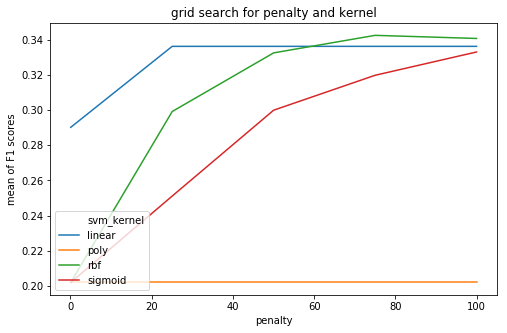

In [164]:
def plot_results_svd(results, title=r'grid search for penalty and kernel'):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x='svm_penalty',
    y='f1 scores',
    hue = 'svm_kernel',
    data=results)
    ax.set_xlabel(r'penalty')
    ax.set_ylabel('mean of F1 scores')
    ax.set_title(title)
    ax.legend(loc='lower left')
plot_results_svd(results)